In [1]:
from IPython.display import Audio, display
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import sys
import random
import librosa.display
import soundfile as psf
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import umap
import umap.plot

sys.path.append('..')
from src.instrument_recognizer import load_data, sample_n_instrument_examples, extract_mfcc_features, \
    extract_mfcc_features_for_track, compute_summary_statistics, invert_mfccs
from src.instrument_recognition_experiment import run, run_condition

%matplotlib inline

# Homework 3
<div class="alert alert-block alert-success">

For this assignment, do not create a separate PDF. I will look to this notebook for your plots, analysis, and responses.

</div>

## Part 1 - Attributes of MFCCs

<div class="alert alert-block alert-success">
    
In this section, you will investigate Mel-Frequency Cepstral Coefficients (MFCCs)
    
</div>

<div class="alert alert-block alert-success">
    
As a refresher, the steps for computing MFCCs are follows:
    
1. Calculate magnitude spectrum
1. Calculate the mel-scale filterbank response
1. Take log of the filterbank response
1. Perform discrete cosine transform (DCT) on the vector from 3.
1. Choose the several (e.g., 40) lowest-order DCT coefficients

Let's extract MFCCs from a few instruments to get a feel for them.
</div>

In [2]:
PIANO_PATH = "../data/piano.wav"
MARIMBA_PATH = "../data/marimba.wav"
HORN_PATH = "../data/horn.wav"
N_MFCC = 40
HOP_LENGTH = 512
SR = 44100

piano_mfccs = extract_mfcc_features_for_track(PIANO_PATH, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)
marimba_mfccs = extract_mfcc_features_for_track(MARIMBA_PATH, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)
horn_mfccs = extract_mfcc_features_for_track(HORN_PATH, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)

<div class="alert alert-block alert-success">
    Listen to the files:
</div>

In [3]:
display(Audio(PIANO_PATH))
display(Audio(MARIMBA_PATH))
display(Audio(HORN_PATH))

<div class="alert alert-block alert-success">
    Plot the MFCCs
</div>

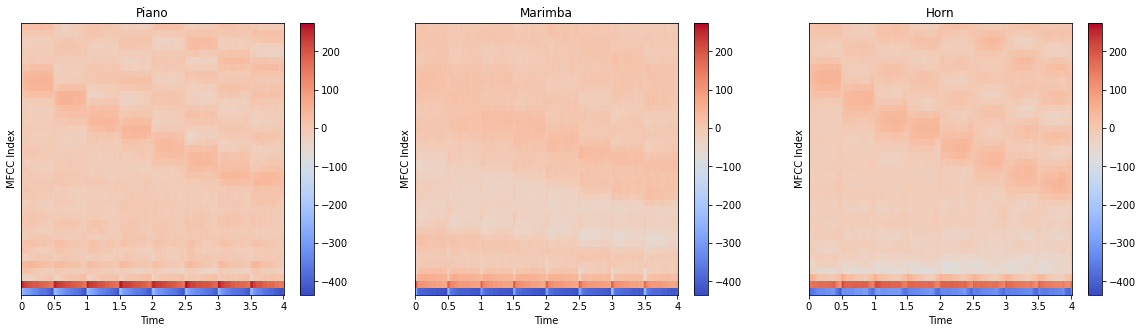

In [4]:
plt.figure(figsize=(20,5))
amin = np.min(np.hstack([piano_mfccs, marimba_mfccs, horn_mfccs]))
amax = np.max(np.hstack([piano_mfccs, marimba_mfccs, horn_mfccs]))

plt.subplot(1,3,1)
librosa.display.specshow(piano_mfccs, x_axis='time', hop_length=HOP_LENGTH, sr=SR, vmin=amin, vmax=amax)
plt.ylabel('MFCC Index')
plt.title('Piano')
plt.colorbar()

plt.subplot(1,3,2)
librosa.display.specshow(marimba_mfccs, x_axis='time', hop_length=HOP_LENGTH, sr=SR, vmin=amin, vmax=amax)
plt.ylabel('MFCC Index')
plt.title('Marimba')
plt.colorbar()

plt.subplot(1,3,3)
librosa.display.specshow(horn_mfccs, x_axis='time', hop_length=HOP_LENGTH, sr=SR, vmin=amin, vmax=amax)
plt.ylabel('MFCC Index')
plt.title('Horn')
plt.colorbar()

<div class="alert alert-block alert-success">
    To better compare these instruments, let's concatenate the files together. Let's also standardize the coefficients to see the temporal patterns better (e.g. subtract the mean and divide by the standard deviation for each coefficient index).
</div>

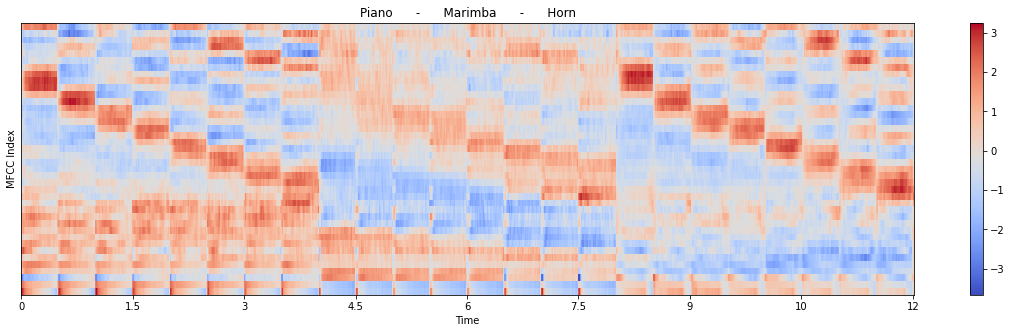

In [5]:
scaler = StandardScaler()

plt.figure(figsize=(20,5))

instrument_mfccs = np.hstack([piano_mfccs, marimba_mfccs, horn_mfccs])

librosa.display.specshow(scaler.fit_transform(instrument_mfccs.T).T, x_axis='time', hop_length=HOP_LENGTH, sr=SR)
plt.ylabel('MFCC Index')
plt.title('Piano      -      Marimba      -      Horn')
plt.colorbar()

<div class="alert alert-block alert-success">
Notice that the top half of the plot seems to vary a lot as the pitch changes, but the bottom half is much more stable as the pitch changes, changing mostly when the instrument class changes.<br />
    
Let's listen to what it would sound like if we tried to invert the first 40 MFCCs as shown above. 
</div>

In [6]:
N_MFCCS_TO_KEEP = 40

x = invert_mfccs(instrument_mfccs[:N_MFCCS_TO_KEEP,:], hop_length=HOP_LENGTH, sr=SR)
Audio(x, rate=SR)

<div class="alert alert-block alert-success">
    
**1. Why doesn't the inversion sound like the original audio recordings?**

</div>

The inversion sounds different because we change the number of the mfcc.

<div class="alert alert-block alert-success">
Notice that with 40 MFCC coefficients you can still clearly hear the pitch as well.<br />
    
**2. Reduce `N_MFCCS_TO_KEEP` and invert the MFCCs until you can't hear the changes in pitch (or its minimal), but you can still discern between the instruments.**
</div>

In [7]:
# YOUR CODE GOES HERE
N_MFCCS_TO_KEEP = 7

x = invert_mfccs(instrument_mfccs[:N_MFCCS_TO_KEEP,:], hop_length=HOP_LENGTH, sr=SR)
Audio(x, rate=SR)

<div class="alert alert-block alert-success">
    
**3. How many coefficients did you keep?**

</div>

7, can't really tell the difference while the pitch changes but can tell when the instrument changes.

<div class="alert alert-block alert-success">   
    
**4. Plot the standardized MFCCs again, only including the coefficients kept in the previous step.**
    
</div>

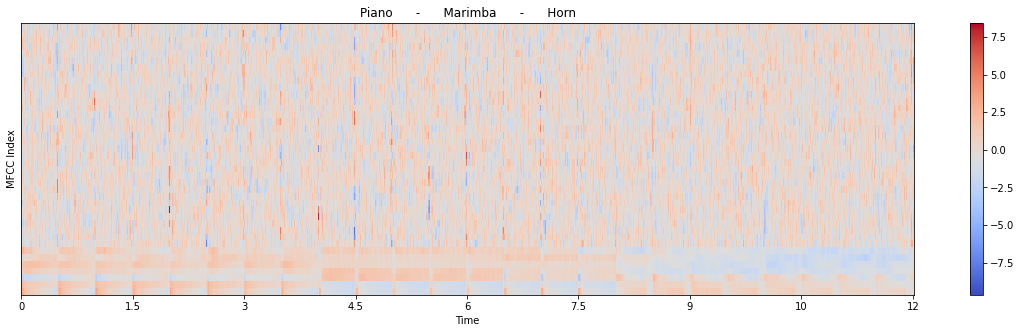

In [8]:
# YOUR CODE GOES HERE
scaler = StandardScaler()
plt.figure(figsize=(20,5))

x_mfccs = librosa.feature.mfcc(x, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)

librosa.display.specshow(scaler.fit_transform(x_mfccs.T).T, x_axis='time', hop_length=HOP_LENGTH, sr=SR)
plt.ylabel('MFCC Index')
plt.title('Piano      -      Marimba      -      Horn')
plt.colorbar()

<div class="alert alert-block alert-success">
    
**5. Describe the new plot.**

</div>

The upper half of the plot where changes with the pitches is now fuzzy and the color on the buttom half is lighter.

<div class="alert alert-block alert-success">   

**6.**
    
1. Listen to "../data/piano_amplitude.wav". The notes in this recordings don't vary in pitch but do vary in amplitude.
1. Compute and plot the standardized MFCCs of "../data/piano_amplitude.wav".

</div>

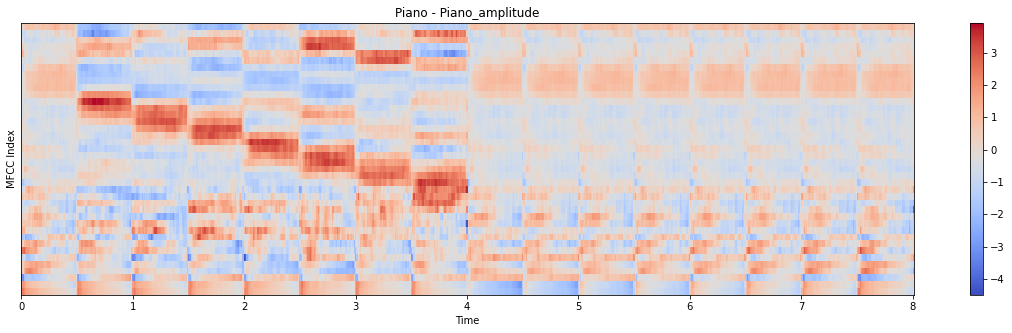

In [9]:
PIANO_AMPLITUDE_PATH = "../data/piano_amplitude.wav"
# YOUR CODE GOES HERE
display(Audio(PIANO_AMPLITUDE_PATH))
piano_amplitude_mfccs = extract_mfcc_features_for_track(PIANO_AMPLITUDE_PATH, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)

scaler = StandardScaler()

plt.figure(figsize=(20,5))

instrument_mfccs = np.hstack([piano_mfccs, piano_amplitude_mfccs])

librosa.display.specshow(scaler.fit_transform(instrument_mfccs.T).T, x_axis='time', hop_length=HOP_LENGTH, sr=SR)
plt.ylabel('MFCC Index')
plt.title('Piano - Piano_amplitude')
plt.colorbar()

<div class="alert alert-block alert-success">   

Notice how much the amplitude affects the first coefficient (the bottom row in the MFCC plot). This is because the first coefficient represent the DC offset of the log-scaled mel spectrogram. To built an instrument classifier, we ideally want a representation that is invariant to both pitch and amplitude but discriminative between timbres. Thus, this first coefficient, as well as the higher coefficients that encode the pitch, are typically removed when MFCCs are used for timbre classification tasks like instrument recognition.
    
</div>

## Part 2 - Scatterplotting MFCC representations

<div class="alert alert-block alert-success">
    
In this section, you will visualize 2D projections of the MFCC representations by instrument.
    
</div>

<div class="alert alert-block alert-success">   

First, let's load in a dataset and extract the MFCCs.
    
</div>

In [10]:
training_tracks, test_tracks, validation_tracks = load_data()

In [11]:
training_mfccs = extract_mfcc_features(training_tracks, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)
validation_mfccs = extract_mfcc_features(validation_tracks, n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR)
training_labels = np.array([t.instrument for t in training_tracks.values()])
validation_labels = np.array([t.instrument for t in validation_tracks.values()])

<div class="alert alert-block alert-success">   

One way to build an instrument classifier is to classify each individual frame. So, let's reshape the data to be frame-wise rather than clip-wise. Then let's use UMAP to visualize a 2-dimensional projection of the 40-dimensional MFCC vectors.
    
</div>

In [12]:
# reshape so that each row is a frame rather than a clip
training_mfccs_fw = np.moveaxis(training_mfccs, 2, 1).reshape([-1, 40])
training_labels_fw = np.repeat(training_labels, training_mfccs.shape[2])

validation_mfccs_fw = np.moveaxis(validation_mfccs, 2, 1).reshape([-1, 40])
validation_labels_fw = np.repeat(validation_labels, validation_mfccs.shape[2])

In [13]:
# sample 10000 points to speed up UMAP
sample_idxs = np.random.choice(np.arange(training_mfccs_fw.shape[0]), 10000, replace=False)
training_mfccs_fw_sample, training_labels_fw_sample = training_mfccs_fw[sample_idxs], training_labels_fw[sample_idxs]

Silhouette score = 0.010430042631924152


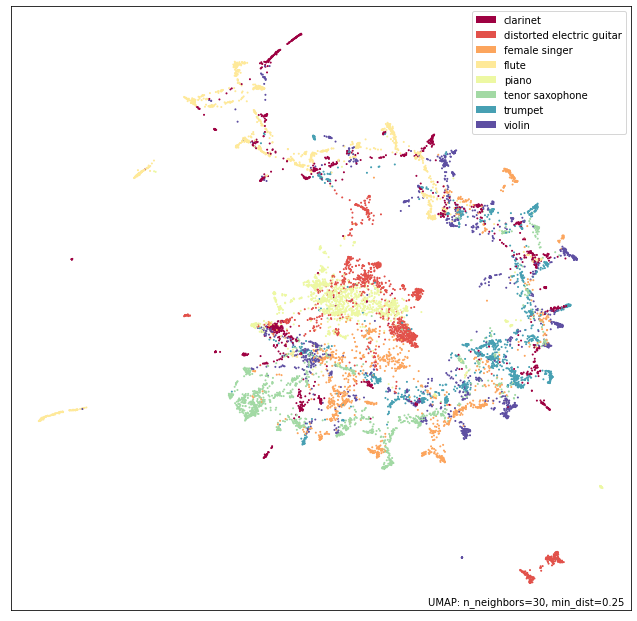

In [14]:
scaler = StandardScaler()
reducer = umap.UMAP(n_neighbors=30, min_dist=0.25)
feats = training_mfccs_fw_sample
feats = scaler.fit_transform(feats)
reducer.fit(feats)
umap.plot.points(reducer, labels=training_labels_fw_sample)
ss = silhouette_score(training_mfccs_fw_sample, training_labels_fw_sample)
print(f"Silhouette score = {ss}")

<div class="alert alert-block alert-success">   

Notice that there is a lot of overlap in the classes when we include all 40-dimensions. Ideally we want the each instrument to group together into their own little clusters, since this would indicate that the classes may be separable by a classifier.<br />
    
The [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) measure how clustered classes are. For these features it is 0.015.
    
To improve the clustering of the classes, let's focus on the characteristics of the frames that are invariant to pitch and loudness.
    
**7. Make another UMAP plot only using the dimensions indexed by `1:N_MFCCS_TO_KEEP` as disucssed before. Calculate the silhouette score as well.**
    
</div>

In [15]:
# YOUR CODE GOES HERE
a = []
for i in training_mfccs:
    a.append(invert_mfccs(i[1:N_MFCCS_TO_KEEP, :], hop_length=HOP_LENGTH, sr=SR))
b = []
for j in validation_mfccs:
    b.append(invert_mfccs(j[1:N_MFCCS_TO_KEEP, :], hop_length=HOP_LENGTH, sr=SR))

Silhouette score = 0.021766629070043564


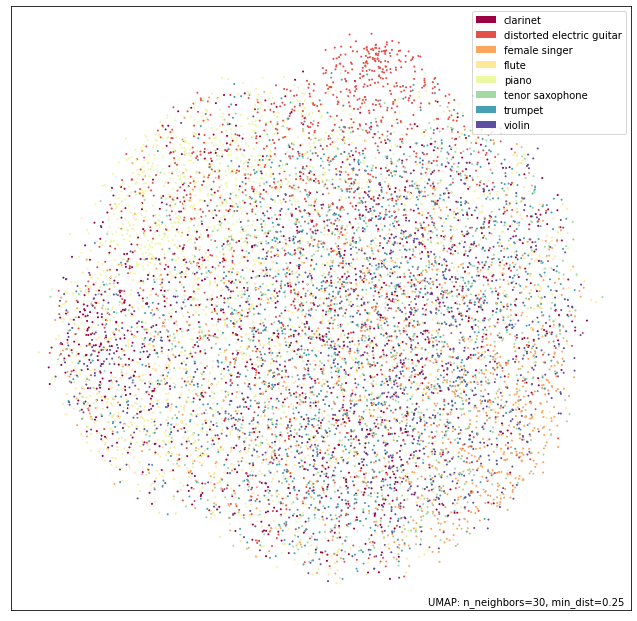

In [16]:
a = np.array(a)
b = np.array(b)

x_training_mfccs = []
for i in range(len(a)):
    x_training_mfccs.append(librosa.feature.mfcc(a[i], n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR))
x_training_mfccs = np.array(x_training_mfccs)

x_validation_mfccs = []
for j in range(len(b)):
    x_validation_mfccs.append(librosa.feature.mfcc(b[j], n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR))
x_validation_mfccs = np.array(x_validation_mfccs)

x_training_labels = np.array([t.instrument for t in training_tracks.values()])
x_validation_labels = np.array([t.instrument for t in validation_tracks.values()])

x_training_mfccs_fw = np.moveaxis(x_training_mfccs, 2, 1).reshape([-1, 40])
x_training_labels_fw = np.repeat(x_training_labels, x_training_mfccs.shape[2])

x_validation_mfccs_fw = np.moveaxis(x_validation_mfccs, 2, 1).reshape([-1, 40])
x_validation_labels_fw = np.repeat(x_validation_labels, x_validation_mfccs.shape[2])

x_sample_idxs = np.random.choice(np.arange(x_training_mfccs_fw.shape[0]), 10000, replace=False)
x_training_mfccs_fw_sample, x_training_labels_fw_sample = x_training_mfccs_fw[x_sample_idxs], x_training_labels_fw[x_sample_idxs]

scaler = StandardScaler()
reducer = umap.UMAP(n_neighbors=30, min_dist=0.25)
feats = x_training_mfccs_fw_sample
feats = scaler.fit_transform(feats)
reducer.fit(feats)
umap.plot.points(reducer, labels=x_training_labels_fw_sample)
ss = silhouette_score(x_training_mfccs_fw_sample, x_training_labels_fw_sample)
print(f"Silhouette score = {ss}")

<div class="alert alert-block alert-success">
    
**8. Describe the new plot and silhouette score in relation to those for the previous set of features.**

</div>

The new silhouette score is much higher than the original one. The dots spread evenly than the previous one.

<div class="alert alert-block alert-success">
    
Sometimes we don't want to classify every frame, but rather classify the entire clip. This is also typically faster computationally. Therefore, we need to summarize the features for the clip to have one vector we input into the model. There are a lot of ways of doing this, e.g. codebook-based representation learning, Gaussian mixture models, etc. However, the simplest is to just compute statistics of the features over the clip, e.g. compute the mean, variance, etc. of each dimensions over the recording clip's frames. For a start, let's just try computing the mean (see the arguments for `instrument_recognizer.compute_summary_statistics`) and then look at the UMAP projection.

</div>

Silhouette score = 0.02274611033499241


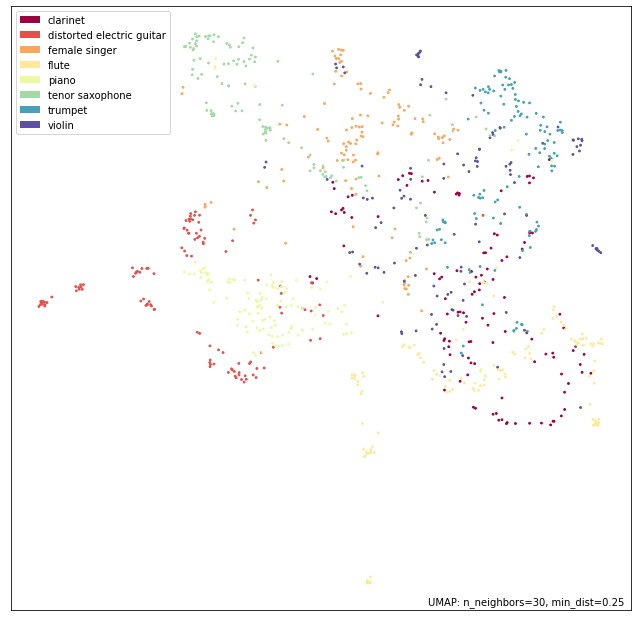

In [17]:
scaler = StandardScaler()

training_mfccs = extract_mfcc_features(training_tracks, n_mfcc=N_MFCC, include_dc=True)

feats = compute_summary_statistics(training_mfccs, include_mean=True)
feats = scaler.fit_transform(feats)

reducer = umap.UMAP(n_neighbors=30, min_dist=0.25)
reducer.fit(feats)
umap.plot.points(reducer, labels=training_labels)
ss = silhouette_score(feats, training_labels)
print(f"Silhouette score = {ss}")

<div class="alert alert-block alert-success">
    
**9. Repeat the above, but remove the DC component and only include `N_MFCCS_TO_KEEP`.**

</div>

Silhouette score = -0.004856887739151716


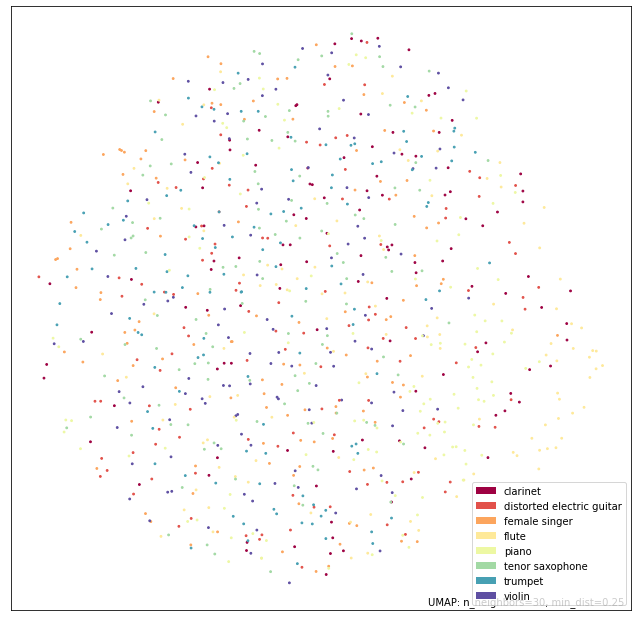

In [18]:
# YOUR CODE GOES HERE
scaler = StandardScaler()

training_mfccs = extract_mfcc_features(training_tracks, n_mfcc=N_MFCC, include_dc=False)
x = []
for i in training_mfccs:
    x.append(invert_mfccs(i[1:N_MFCCS_TO_KEEP, :], hop_length=HOP_LENGTH, sr=SR))
x = np.array(x)

x_training_mfccs = []
for i in range(len(x)):
    x_training_mfccs.append(librosa.feature.mfcc(x[i], n_mfcc=N_MFCC, hop_length=HOP_LENGTH, sr=SR))
x_training_mfccs = np.array(x_training_mfccs)

feats = compute_summary_statistics(x_training_mfccs, include_mean=True)
feats = scaler.fit_transform(feats)

reducer = umap.UMAP(n_neighbors=30, min_dist=0.25)
reducer.fit(feats)
umap.plot.points(reducer, labels=training_labels)
ss = silhouette_score(feats, training_labels)
print(f"Silhouette score = {ss}")

<div class="alert alert-block alert-success">
    
**10. Describe the new plot and silhouette score in relation to those for the previous set of features.**

</div>

*YOUR RESPONSE GOES HERE*
The score is now negative, and the dots is still spread evenly.

## Part 3 - Instrument classification using MFCCs

<div class="alert alert-block alert-success">
    
While the silhouette score indicates how much classes cluster together, that doesn't always translate into better classification. Let's run an experiment where we vary the number of mfccs, train a K Nearest Neighbor classifier, and evaluate on the validation set. See `instrument_recognition_experiment.run` for details on the arguments.

</div>

100%|██████████| 8/8 [02:30<00:00, 18.78s/it]


accuracy_score condition_id
0           0.735     n_mfcc=5
1           0.770    n_mfcc=10
2           0.695    n_mfcc=15
3           0.625    n_mfcc=20
4           0.600    n_mfcc=25
5           0.610    n_mfcc=30
6           0.625    n_mfcc=35
7           0.625    n_mfcc=40

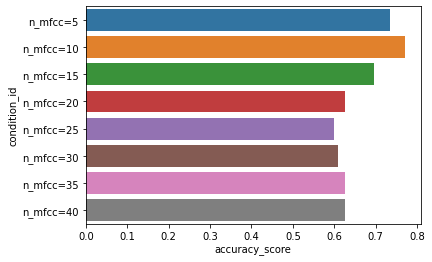

In [19]:
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

<div class="alert alert-block alert-success">
    
**11. What condition performed the best? How did this compare to the number MFCCs you kept in the listening experiment?**

</div>


The model perform best when the n_mfcc=10,which is close to the number MFCCs I kept in the listening experiment, 7

<div class="alert alert-block alert-success">
    
**12. Repeat the same experiment but do not include the DC component, i.e change `feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True)` to `feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=False)`**

</div>

100%|██████████| 8/8 [02:31<00:00, 18.96s/it]


accuracy_score condition_id
0           0.555     n_mfcc=5
1           0.695    n_mfcc=10
2           0.675    n_mfcc=15
3           0.680    n_mfcc=20
4           0.630    n_mfcc=25
5           0.625    n_mfcc=30
6           0.640    n_mfcc=35
7           0.605    n_mfcc=40

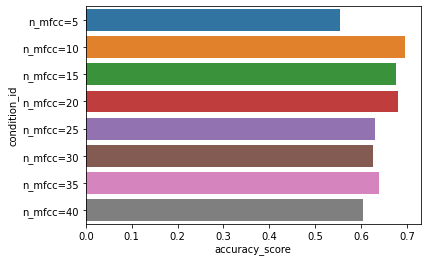

In [20]:
# YOUR CODE GOES HERE
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

<div class="alert alert-block alert-success">
    
**13. Was the performance better with or without the DC component (the first MFCC)? Why do you think that is?**

</div>

It performance better with the DC component. Maybe its because the more detail the better so better not remove anything from the data.

<div class="alert alert-block alert-success">
    
Another common practice when using MFCCs is to calculate the 'deltas' and the 'delta-deltas'. The 'deltas' are approximations of the first derivative of the MFCCs in time. And 'delta-deltas' are approximations of the second derivative of the MFCCs in time. See `librosa.feature.delta` for details. These features capture some of the temporal dynamics, but they don't always help.<br />
    
To extract these, pass in `include_deltas=True` and `include_delta_deltas=True` as arguments to `extract_mfcc_features`.<br />
    
**14. Take the best model from the previous experiments as a base, and run a new experiment with all 4 combinations of including deltas and delta-deltas.**
</div>

100%|██████████| 8/8 [02:45<00:00, 20.68s/it]


accuracy_score condition_id
0           0.655     n_mfcc=5
1           0.660    n_mfcc=10
2           0.620    n_mfcc=15
3           0.555    n_mfcc=20
4           0.485    n_mfcc=25
5           0.485    n_mfcc=30
6           0.475    n_mfcc=35
7           0.440    n_mfcc=40

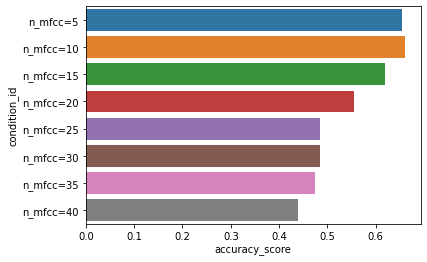

In [21]:
# YOUR CODE GOES HERE
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=True, include_delta_deltas=True)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:39<00:00, 19.88s/it]


accuracy_score condition_id
0           0.650     n_mfcc=5
1           0.700    n_mfcc=10
2           0.610    n_mfcc=15
3           0.605    n_mfcc=20
4           0.525    n_mfcc=25
5           0.530    n_mfcc=30
6           0.515    n_mfcc=35
7           0.500    n_mfcc=40

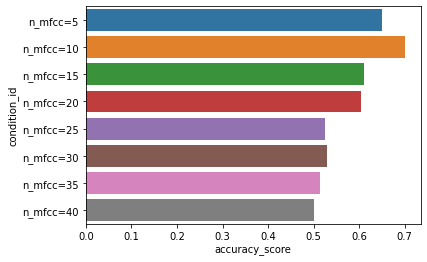

In [22]:
# YOUR CODE GOES HERE
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=True, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:38<00:00, 19.84s/it]


accuracy_score condition_id
0           0.720     n_mfcc=5
1           0.740    n_mfcc=10
2           0.650    n_mfcc=15
3           0.625    n_mfcc=20
4           0.590    n_mfcc=25
5           0.560    n_mfcc=30
6           0.505    n_mfcc=35
7           0.480    n_mfcc=40

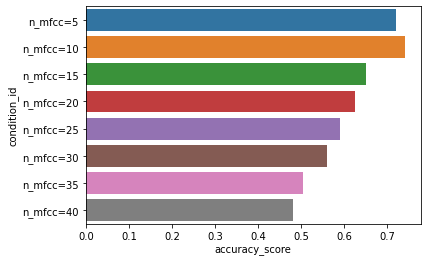

In [23]:
# YOUR CODE GOES HERE
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=True)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:31<00:00, 18.97s/it]


accuracy_score condition_id
0           0.735     n_mfcc=5
1           0.770    n_mfcc=10
2           0.695    n_mfcc=15
3           0.625    n_mfcc=20
4           0.600    n_mfcc=25
5           0.610    n_mfcc=30
6           0.625    n_mfcc=35
7           0.625    n_mfcc=40

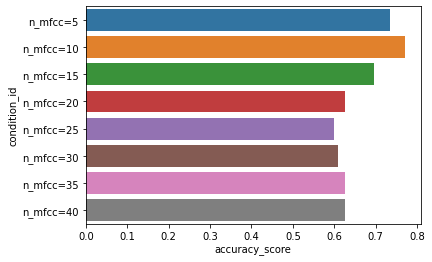

In [24]:
# YOUR CODE GOES HERE
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

<div class="alert alert-block alert-success">
    
**15. Did they help or not? What was the best combination?**

</div>

No, they don't help. The best combination is when include_deltas=False and include_delta_deltas=False

<div class="alert alert-block alert-success">
    When computing the summary statistcs, so far we've just been computing the mean. Try computing additional statistics like variance, max, and min. <br />
    
**16. Using your best model from the last experiment, try running the experiment with these additional statistics**
</div>

100%|██████████| 8/8 [02:39<00:00, 19.91s/it]


accuracy_score condition_id
0           0.715     n_mfcc=5
1           0.725    n_mfcc=10
2           0.675    n_mfcc=15
3           0.625    n_mfcc=20
4           0.615    n_mfcc=25
5           0.605    n_mfcc=30
6           0.635    n_mfcc=35
7           0.575    n_mfcc=40

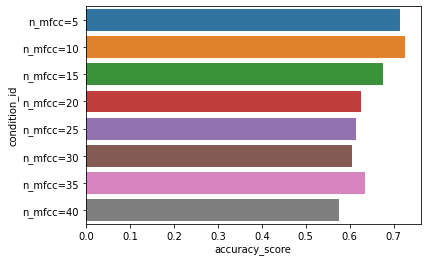

In [25]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=False, include_min=False),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:59<00:00, 22.44s/it]


accuracy_score condition_id
0           0.775     n_mfcc=5
1           0.740    n_mfcc=10
2           0.710    n_mfcc=15
3           0.690    n_mfcc=20
4           0.670    n_mfcc=25
5           0.650    n_mfcc=30
6           0.635    n_mfcc=35
7           0.615    n_mfcc=40

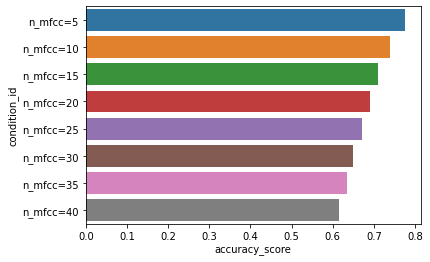

In [26]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=False),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:32<00:00, 19.07s/it]


accuracy_score condition_id
0           0.755     n_mfcc=5
1           0.770    n_mfcc=10
2           0.725    n_mfcc=15
3           0.710    n_mfcc=20
4           0.710    n_mfcc=25
5           0.675    n_mfcc=30
6           0.670    n_mfcc=35
7           0.625    n_mfcc=40

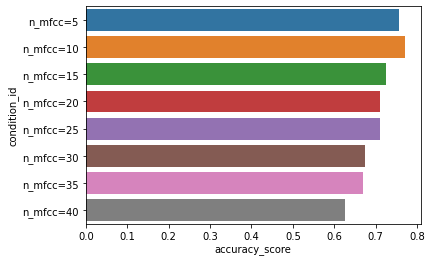

In [27]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=True),
                      preprocessor=Pipeline([('scaler', StandardScaler()),]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

<div class="alert alert-block alert-success">
    
**17. Did they help or not? What was the best combination?**

</div>

They do help improve the performance. The best combination is when I include them all.

<div class="alert alert-block alert-success">
Thus far, we have only been using the StandardScaler for preprocessing. This just normalizes each dimension of the feature vectors. Try pre-processing with Linear Discriminant Analysis, LDA. This uses the training labels to learn a projection of the data that tries to cluster the classes more. To use it set `preprocessor = Pipeline([('lda', LinearDiscriminantAnalysis())])`<br />
    
**18. Plot the UMAP visualization of the transformed data. Re-run the last experiment (mean vs all stats) with LDA preprocessing instead of the StandardScaler**
</div>

100%|██████████| 8/8 [02:32<00:00, 19.02s/it]


accuracy_score condition_id
0           0.760     n_mfcc=5
1           0.785    n_mfcc=10
2           0.755    n_mfcc=15
3           0.740    n_mfcc=20
4           0.770    n_mfcc=25
5           0.770    n_mfcc=30
6           0.750    n_mfcc=35
7           0.745    n_mfcc=40

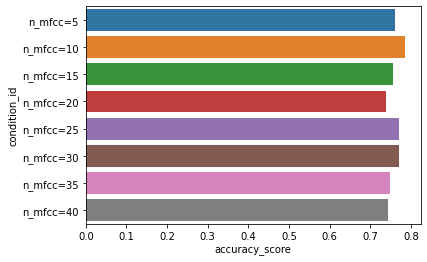

In [28]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=True),
                      preprocessor = Pipeline([('lda', LinearDiscriminantAnalysis())]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=5))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

<div class="alert alert-block alert-success">
    
**19. How did that change the performance?**

</div>

The accuracy score become higher on every n_mfcc.

<div class="alert alert-block alert-success">
Thus far, we have defaulted to using 5 nearest neighbors in the KNN, but this may be suboptimal.<br />
    
**20. Using your best model thus far, run an experiment where you try a range of `n_nearestneighbor` values, e.g `[1,2,3,5,10,15,25,30]`**
</div>

100%|██████████| 8/8 [02:34<00:00, 19.31s/it]


accuracy_score condition_id
0           0.740     n_mfcc=5
1           0.795    n_mfcc=10
2           0.750    n_mfcc=15
3           0.735    n_mfcc=20
4           0.755    n_mfcc=25
5           0.770    n_mfcc=30
6           0.770    n_mfcc=35
7           0.735    n_mfcc=40

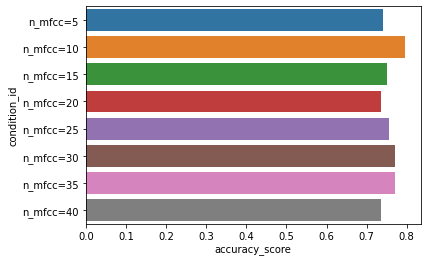

In [29]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=True),
                      preprocessor = Pipeline([('lda', LinearDiscriminantAnalysis())]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=30))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:31<00:00, 18.99s/it]


accuracy_score condition_id
0           0.740     n_mfcc=5
1           0.795    n_mfcc=10
2           0.765    n_mfcc=15
3           0.760    n_mfcc=20
4           0.765    n_mfcc=25
5           0.760    n_mfcc=30
6           0.765    n_mfcc=35
7           0.735    n_mfcc=40

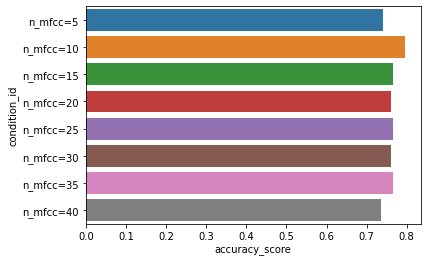

In [30]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=True),
                      preprocessor = Pipeline([('lda', LinearDiscriminantAnalysis())]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=10))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

100%|██████████| 8/8 [02:34<00:00, 19.27s/it]


accuracy_score condition_id
0           0.740     n_mfcc=5
1           0.800    n_mfcc=10
2           0.760    n_mfcc=15
3           0.760    n_mfcc=20
4           0.770    n_mfcc=25
5           0.775    n_mfcc=30
6           0.750    n_mfcc=35
7           0.735    n_mfcc=40

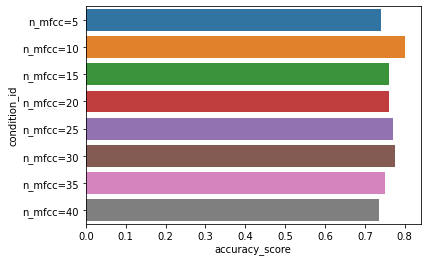

In [31]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
base_condition = dict(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=N_MFCC, include_dc=True),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=True),
                      preprocessor = Pipeline([('lda', LinearDiscriminantAnalysis())]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=3))

# create conditions dictionary, varying n_mfcc
conditions = []
for n_mfcc in range(5, 45, 5):
    condition = base_condition.copy()
    condition.update({'feature_fn_kwargs':dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False)})
    conditions.append((f'n_mfcc={n_mfcc}', condition))

# run the experiment
results = run(dict(conditions))

# plot the results
sns.barplot(data=results, x='accuracy_score', y='condition_id')

results

<div class="alert alert-block alert-success">
Ok. Now, let's evaluate your best model thus far on the test split, i.e. when calling `run` change `test_split='validation'` to `test_split='test'`.<br />
    
**21. Plot a confusion matrix using the results from the test split. See `sklearn.metrics.confusion_matrix` and `sklearn.metrics.ConfusionMatrixDisplay`**
</div>

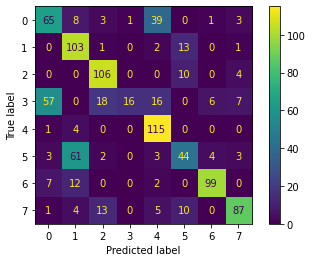

In [32]:
# YOUR CODE GOES HERE
# include_mean=False, include_variance=False, include_max=False, include_min=False
# construction base condition
n_mfcc = 10

# run the experiment
result, test_labels, pred_labels = run_condition(feature_fn=extract_mfcc_features, 
                      feature_fn_kwargs=dict(n_mfcc=n_mfcc, include_dc=True, include_deltas=False, include_delta_deltas=False),
                      summary_fn=compute_summary_statistics, 
                      summary_fn_kwargs=dict(include_mean=True, include_variance=True, include_max=True, include_min=True),
                      preprocessor = Pipeline([('lda', LinearDiscriminantAnalysis())]),
                      classifier_fn=KNeighborsClassifier, 
                      classifier_kwargs=dict(n_neighbors=3),
                      test_split="test",
                      return_predictions=True)

# compute the confusion matrix
cm = confusion_matrix(test_labels, pred_labels)

# plot the matrix
ConfusionMatrixDisplay(cm).plot()

<div class="alert alert-block alert-success">
    
**22. Which class has the most true positives? Which class has the fewest true positives? What do the class with the fewest true positives get confused with? What are some other common confusions?**

</div>

class 4 has the most true positive while class 3 has the fewest true positive. It is confused with class 0, class 2, and class 7 mostly. Class 5 is confused with class 1, class 0 is confused with class 4, and the rest of the classes seem fine.

<div class="alert alert-block alert-success">
    
**23. Given this error analysis, give one example of a "data-centric" approach to improving the model's performance.**

</div>

We can collect more data about the classes that were confused.